# 目录

* [1. 读入数据](#1)
* [2. 使用VGG16进行迁移学习](#2)
    * [2.1修改VGG16网络](#2.1)
    * [2.2 数据增强](#2.2)
    * [2.3 模型预测](#2.3)


<a id=1></a>
# 1. 读入数据

本案例从网上分别下载了五种不同品种的猫的图片，由于数据量较小，因此使用VGG16进行迁移学习，并使用数据增强的方法来防止过拟合。

导入所需的库：

In [28]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

定义读取图像的函数，并统一图片大小，且转换成矩阵形式：

In [29]:
def read_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224), Image.ANTIALIAS)
    img_arr = np.array(img.convert('RGB'))
    return np.array(img_arr)

`train_image`文件夹和`test_image`文件夹分别保存训练数据集合测试数据集，而这两个文件夹下又分别包含了孟买猫，布偶猫，暹罗猫，波斯猫，英国短毛猫这五个文件夹，里面保存了图片文件，因此可以使用如下方法读取图像文件，并生成训练集和测试集：

In [30]:
path = './train_image' #文件夹目录
files= os.listdir(path) #得到文件夹下的所有文件夹名称
x_train = []
y_train = []
s = 0    #用于给标签序数化
labels = {}  #用于记录标签与数字的对应关系
for file in files: #遍历各类文件夹 
    labels[s]=file
    for image_name in os.listdir(path+"/"+file): #获取每类文件夹的文件名
        x_train.append(read_image(path+"/"+file+"/"+image_name)) #读取图像文件
        y_train.append(s)
    s+=1
    
x_train = np.array(x_train)/255.0
y_train = np.array(y_train).reshape(-1,1)

In [31]:
path = './test_image' #文件夹目录
x_test = []
y_test = []
s=0
for file in files: #用于训练集相同的文件顺序遍历打开文件夹
    for image_name in os.listdir(path+"/"+file): #获取每类文件夹的文件名
        x_test.append(read_image(path+"/"+file+"/"+image_name)) #读取图像文件
        y_test.append(s)
    s+=1
    
x_test = np.array(x_test)/255.0
y_test = np.array(y_test).reshape(-1,1)

观察数量标签对应品种以及数据集大小：

In [32]:
print(labels)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

{0: '孟买猫', 1: '布偶猫', 2: '暹罗猫', 3: '波斯猫', 4: '英国短毛猫'}
(397, 224, 224, 3) (397, 1)
(101, 224, 224, 3) (101, 1)


398张224×224的训练图片，以及101张224×224的测试图片。
打乱数据集：

In [33]:
np.random.seed(20)
np.random.shuffle(x_train) 
np.random.seed(20)
np.random.shuffle(y_train)

np.random.seed(20)
np.random.shuffle(x_test) 
np.random.seed(20)
np.random.shuffle(y_test)

观察数据集：

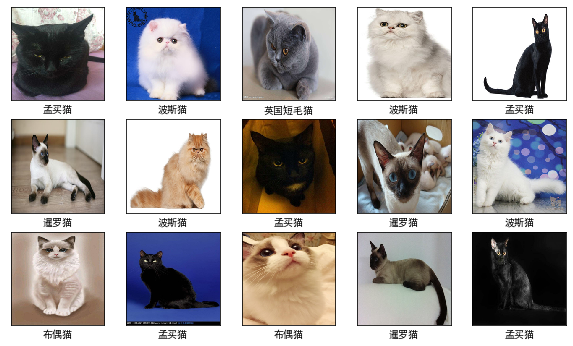

In [34]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()

# 2. 使用VGG16进行迁移学习
<a id=1></a>

## 2.1 修改VGG16网络
<a id=2.1></a>

只修改最后全连接层以及输出层：

In [35]:
from tensorflow.keras.applications import VGG16

vgg16_base = VGG16(weights='imagenet', include_top=False, pooling='avg',input_shape=(224,224,3))
vgg16_base.trainable=False

model_vgg = tf.keras.models.Sequential([
    vgg16_base,
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 14,747,845
Trainable params: 33,157
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
model_vgg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
history_vgg = model_vgg.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_test, y_test))

Train on 397 samples, validate on 101 samples
Epoch 1/15
397/397 [==============================] - 197s 496ms/sample - loss: 1.6578 - accuracy: 0.2569 - val_loss: 1.5017 - val_accuracy: 0.4257
Epoch 2/15
397/397 [==============================] - 251s 633ms/sample - loss: 1.4897 - accuracy: 0.3728 - val_loss: 1.4085 - val_accuracy: 0.6238
Epoch 3/15
397/397 [==============================] - 262s 660ms/sample - loss: 1.3702 - accuracy: 0.4937 - val_loss: 1.2939 - val_accuracy: 0.6139
Epoch 4/15
397/397 [==============================] - 243s 612ms/sample - loss: 1.2643 - accuracy: 0.5542 - val_loss: 1.1944 - val_accuracy: 0.7030
Epoch 5/15
397/397 [==============================] - 269s 679ms/sample - loss: 1.1666 - accuracy: 0.6146 - val_loss: 1.1071 - val_accuracy: 0.7129
Epoch 6/15
397/397 [==============================] - 281s 708ms/sample - loss: 1.0691 - accuracy: 0.6348 - val_loss: 1.0261 - val_accuracy: 0.6832
Epoch 7/15
397/397 [==============================] - 251s 632ms/s

由于我的电脑装载的tensorflow为cpu版本，无法进行大量的计算，因此尝试搬到google colab上运行200个epoch得到结果：

<img src="vgg16_result.png" width="100%">

训练集和测试集的准确率和损失曲线为：

<img src="acc_loss curve.png" width="50%">

训练集上的准确率几乎达到了100%，测试集上的准确率达到87%左右，虽然效果还可以，但两者的准确率相差较大，有点过拟合，毕竟数据量太少了，因此考虑用数据增强的方法增加数据量。

# 2.2 数据增强
<a id=2.2></a>

使用`ImageDataGenerator`方法生成迭代器，可以批量地把图片数据进行随机旋转，偏移，缩放，翻转等操作，`flow_from_directory`则可以从文件夹中读取数据，并得到图片变换的生成器，之后可以批量送入VGG16模型中进行训练。

In [2]:
batch_size = 16
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
#测试集只需要和训练机一样rescale
test_datagen = ImageDataGenerator(rescale=1./255)
#train或者val的每个子目录表示一个类
#训练集生成器
train_generator = train_datagen.flow_from_directory(
        './train_image',  # 训练集路径
        target_size=(224, 224),  # 图片尺寸，自动resize
        batch_size=batch_size,
        class_mode='categorical')  # 标签模式
#验证集生成器
validation_generator = test_datagen.flow_from_directory(
        './test_image',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 397 images belonging to 5 classes.
Found 101 images belonging to 5 classes.


`flow_from_directory`从文件夹读取数据时根据文件夹的子目录自动分类：

In [3]:
train_generator.class_indices

{'孟买猫': 0, '布偶猫': 1, '暹罗猫': 2, '波斯猫': 3, '英国短毛猫': 4}

查看图片数据变换的效果：

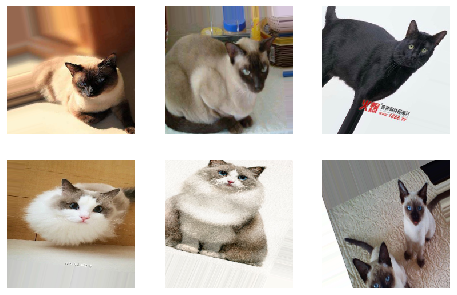

In [50]:
for X_batch, y_batch in train_generator:
    plt.figure(figsize=(8,8)) 
    for i in range(0, 6):
        plt.subplot(331+i) 
        plt.axis('off') 
        plt.imshow(X_batch[i])
    plt.show()
    break

In [49]:
validation_generator.class_indices

{'孟买猫': 0, '布偶猫': 1, '暹罗猫': 2, '波斯猫': 3, '英国短毛猫': 4}

In [6]:
train_generator.samples

397

同样的模型训练数据：

In [7]:
vgg16_base = VGG16(weights='imagenet', include_top=False, pooling='avg',input_shape=(224,224,3))
vgg16_base.trainable=False

model_vgg = tf.keras.models.Sequential([
    vgg16_base,
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 14,747,845
Trainable params: 33,157
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
model_vgg.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
history_vgg = model_vgg.fit_generator(
                            train_generator,
                            steps_per_epoch=train_generator.samples // batch_size,
                            epochs=20,
                            validation_data=validation_generator,
                            validation_steps=validation_generator.samples // batch_size)

Epoch 1/20
 6/24 [======>.......................] - ETA: 6:39 - loss: 2.0310 - accuracy: 0.1458

D:\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - 645s 27s/step - loss: 1.8259 - accuracy: 0.1706 - val_loss: 1.5027 - val_accuracy: 0.4271
Epoch 2/20
24/24 [==============================] - 656s 27s/step - loss: 1.5326 - accuracy: 0.3071 - val_loss: 1.4214 - val_accuracy: 0.5208
Epoch 3/20
24/24 [==============================] - 713s 30s/step - loss: 1.4558 - accuracy: 0.4016 - val_loss: 1.3320 - val_accuracy: 0.6354
Epoch 4/20
24/24 [==============================] - 563s 23s/step - loss: 1.3879 - accuracy: 0.4488 - val_loss: 1.2706 - val_accuracy: 0.6667
Epoch 5/20
24/24 [==============================] - 527s 22s/step - loss: 1.3274 - accuracy: 0.4961 - val_loss: 1.2040 - val_accuracy: 0.6875
Epoch 6/20
24/24 [==============================] - 525s 22s/step - loss: 1.2969 - accuracy: 0.5066 - val_loss: 1.1505 - val_accuracy: 0.6458
Epoch 7/20
24/24 [==============================] - 535s 22s/step - loss: 1.2251 - accuracy: 0.5651 - val_loss: 1.1111 - val_accuracy: 0.6354
Epoch 8/20
24/24 

同样的，把这个模型也放到Google colab中训练得到结果：

<img src="data_aug_vgg16_results.png" width="100%">

训练集和测试集的准确率和损失曲线为：

<img src="data_aug_acc_loss_curve.png" width="50%">

可以看出虽然模型在训练集上的准确率有所下降，但与在测试集上的准确率相差较小，有效的缓解了过拟合。

## 2.3 模型预测
<a id=2.3></a>

`model_vgg`和`model_vgg_aug`是在google colab上运行后保存下来的两个模型，其中`model_vgg_aug`是使用数据增强后的模型，现在重新加载这个模型对一张新的猫片进行预测:

In [38]:
model = tf.keras.models.load_model('./model_vgg_aug')

In [39]:
pre_image = read_image('布偶猫.jpg')
pre_image = pre_image/255.0
predict = model.predict(pre_image[tf.newaxis, ...]).argmax()

In [42]:
pre_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(predict)]

这是一只布偶猫


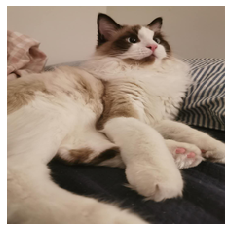

In [45]:
plt.imshow(pre_image)
plt.axis('off')
print("这是一只"+ pre_name)

预测成功。